In [96]:
from scipy.io.wavfile import read as wavread
import numpy as np
from matplotlib import pyplot as plt
import keras
import os

def ms_to_samples(ms, sample_rate=44100):
    return int(ms/1e3*sample_rate)

In [97]:
#sampleset = "HT5 Preamp"
samplesdir = os.path.abspath("..\samples")
opts = [folder for folder in os.listdir(samplesdir) if os.path.isdir(os.path.join(samplesdir,folder))]
print("Samplesets:")
for k in range(len(opts)):
    print("%d: %s" % (k,opts[k]))

# datadir = os.path.abspath("..\data\")
# #relpath("../data/")
# print(datadir)

Samplesets:
0: chorus
1: HT5 clean
2: HT5 dirty
3: HT5 preamp
4: wampler


In [98]:
opt = 3
sampledir = os.path.join(samplesdir,opts[opt])
datadir = os.path.join(os.path.abspath("..\data"),opts[opt])
if not os.path.exists(datadir):
    os.mkdir(datadir)
#print("Samples location: %s\nData location: %s" % (sampledir,datadir))

samples = [file for file in os.listdir(sampledir) if file.endswith('.wav')]
print("Samples:")
for k in range(len(samples)):
    print("%d: %s" % (k,samples[k]))

Samples:
0: stratp1_ht5.wav
1: stratp4_ht5.wav
2: stratp5_ht5.wav


In [99]:
pick = 2
sample_file = os.path.join(sampledir,samples[pick])
(sample_rate,data) = wavread(sample_file)
#get length of audio
duration = data.shape[0]/sample_rate
print("File: %s" % sample_file)
print("NumSamples: %d\nChannels: %d" % data.shape)
print("Duration: %.3fs" % duration)

#normalize signal
norm_data = data/np.iinfo(np.int16).max
G = norm_data[:,0] #channel 0 is L - guitar
E = norm_data[:,1] #channel 1 is R - effect

File: E:\Dev\head-sim\samples\HT5 preamp\stratp5_ht5.wav
NumSamples: 1004672
Channels: 2
Duration: 22.782s


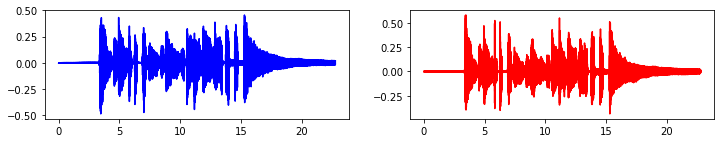

In [100]:
tim = np.linspace(0,duration,data.shape[0])

#make a big figure
plt.figure(figsize=(12,2)) #dpi=80

plt.subplot(1,2,1)
plt.plot(tim,G,'b') #guitar = blue
plt.subplot(1,2,2)
plt.plot(tim,E,'r') #effect = red
plt.show()

In [101]:
#stats
maxg = np.max(G)
maxe = np.max(E)
ming = np.min(G)
mine = np.min(E)
print("|  %-13s|%12s   |\n|  Min  |  Max  |  Min  |  Max  |\n| %+1.3f| %+1.3f| %+1.3f| %+.3f|" % ("Guitar", "Effect", ming,maxg,mine,maxe))

|  Guitar       |      Effect   |
|  Min  |  Max  |  Min  |  Max  |
| -0.487| +0.456| -0.436| +0.580|


In [102]:
#for audio, keep some buffer of samples, 
#array x: audio samples from input, length tbd
#array y: audio samples from output, length tbd
in_buf = ms_to_samples(100)
out_buf = ms_to_samples(1)
print("Number of datapoints per input: %d" % in_buf)

# first output sample starts at in_buf and last sample needs to be out_buf from the end
numexamples = G.shape[0] - in_buf - out_buf
print("Total number of examples: %d" % numexamples)
print("Memory needed (GiB):\nX: %.4f\nY: %.4f" % (numexamples*in_buf*16/8/1e9,numexamples*out_buf*16/8/1e9))

Number of datapoints per input: 4410
Total number of examples: 1000218
Memory needed (GiB):
X: 8.8219
Y: 0.0880


In [103]:
#numexamples = 10
desired_filesize = 100e6 #size in bytes
ex_per_file = int(np.floor(desired_filesize/(in_buf*2)))
out_filesize = ex_per_file*(in_buf*2)
numfiles = int(np.ceil(numexamples/ex_per_file))

print("Files will be up to %.2fMB\n%d examples per file\n%d files" % (out_filesize/1e6,ex_per_file,numfiles))

Files will be up to 99.99MB
11337 examples per file
89 files


In [93]:
X = np.zeros((ex_per_file,in_buf),dtype=np.float16)
Y = np.zeros((ex_per_file,out_buf),dtype=np.float16)
fn_len = int(np.log10(numfiles))+1
for batch in range(numfiles):
    xfn = os.path.join(datadir,"%0*d_x"%(fn_len,batch))
    yfn = os.path.join(datadir,"%0*d_y"%(fn_len,batch))
    if batch%int(numfiles/10)==0:
        print("batch %0*d complete" % (fn_len,batch))
    if numexamples-batch*ex_per_file < ex_per_file:
        ex_this_file = numexamples-batch*ex_per_file
        X = np.zeros((ex_this_file,in_buf),dtype=np.float16)
        Y = np.zeros((ex_this_file,out_buf),dtype=np.float16)
    else:
        ex_this_file = ex_per_file
            
    for ex in range(ex_this_file):
        start = ex+batch*ex_per_file
        endx = start+in_buf
        endy = endx+out_buf
        X[ex] = G[start:endx]
        Y[ex] = E[endx:endy]   
#    np.save(xfn,X) #comment to prevent writing to disk
#    np.save(yfn,Y) #comment to prevent writing to disk

batch 000 complete
batch 088 complete
batch 176 complete
batch 264 complete
batch 352 complete
batch 440 complete
batch 528 complete
batch 616 complete
batch 704 complete
batch 792 complete
batch 880 complete
